In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
#read stock data csv and set the date as the index
data = pd.read_csv("\\Users\\d117698\\Desktop\\Stock Data\\Sector_Indices_Normalized.csv", parse_dates=['date'],infer_datetime_format=True,index_col='date')

In [16]:
#drop any null columns and explore the data
data.dropna(how='all', axis=1, inplace=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-04-17 to 2024-04-17
Data columns (total 19 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   S&P 500 Health Care (Sector)                                        1259 non-null   float64
 1   S&P 500 Real Estate (Sector)                                        1259 non-null   float64
 2   S&P 500 Industrials (Sector)                                        1259 non-null   float64
 3   S&P 500 Information Technology (Sector)                             1259 non-null   float64
 4   S&P 500 Materials (Sector)                                          1259 non-null   float64
 5   S&P GSCI Unleaded Gasoline TR                                       1259 non-null   float64
 6   S&P GSCI Industrial Metals TR                                       1259 non-null   float64
 7

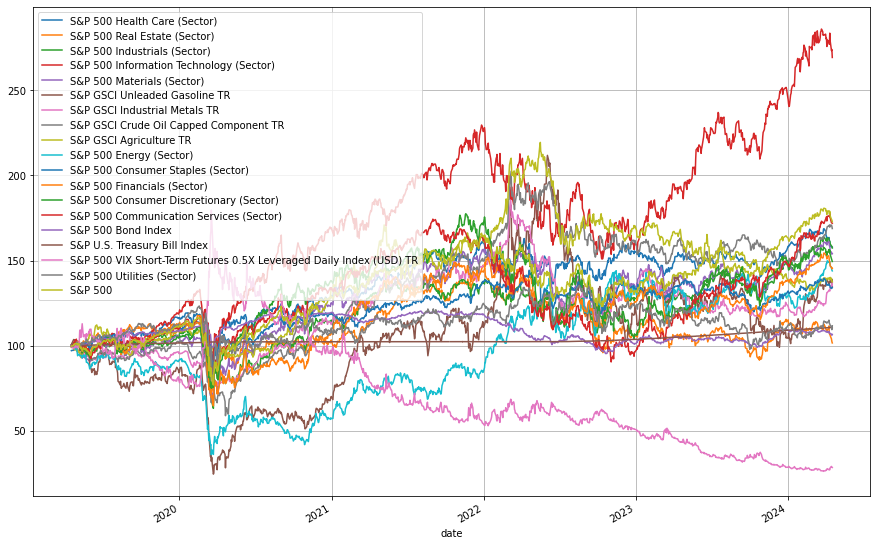

In [17]:
#plot the 5 year normalized performance
data.plot(figsize=(15,10),grid=True)
plt.show()

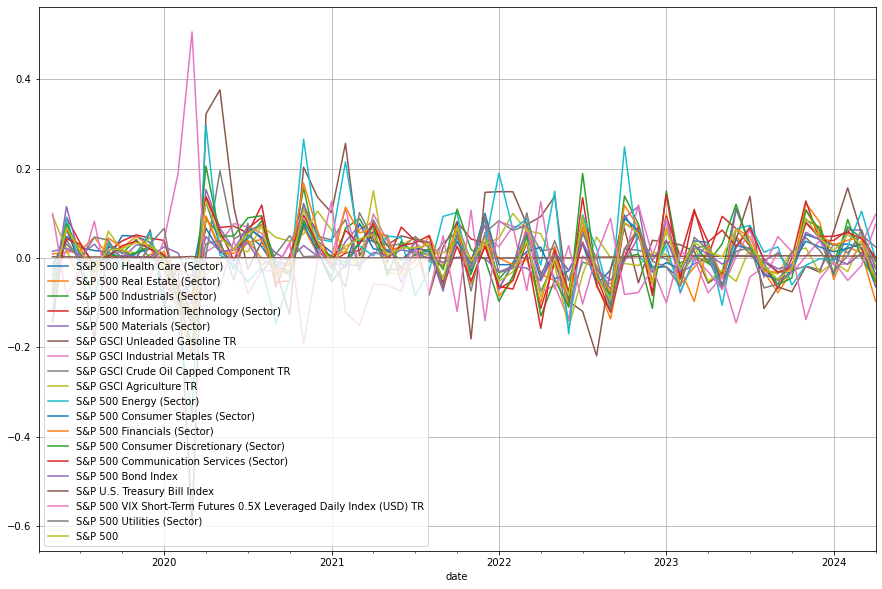

In [18]:
# Calculate Month-end prices 
Monthly_prices = data.resample('M').last()

# Calculate monthly returns 
monthly_returns = Monthly_prices.pct_change()
# Chart monthly returns
monthly_returns.plot(figsize=(15,10),grid=True)
plt.show()

                                                    S&P 500 Health Care (Sector)  \
S&P 500 Health Care (Sector)                                            1.000000   
S&P 500 Real Estate (Sector)                                            0.711428   
S&P 500 Industrials (Sector)                                            0.748302   
S&P 500 Information Technology (Sector)                                 0.693496   
S&P 500 Materials (Sector)                                              0.780838   
S&P GSCI Unleaded Gasoline TR                                           0.401805   
S&P GSCI Industrial Metals TR                                           0.344487   
S&P GSCI Crude Oil Capped Component TR                                  0.395256   
S&P GSCI Agriculture TR                                                 0.078552   
S&P 500 Energy (Sector)                                                 0.484410   
S&P 500 Consumer Staples (Sector)                                       0.78

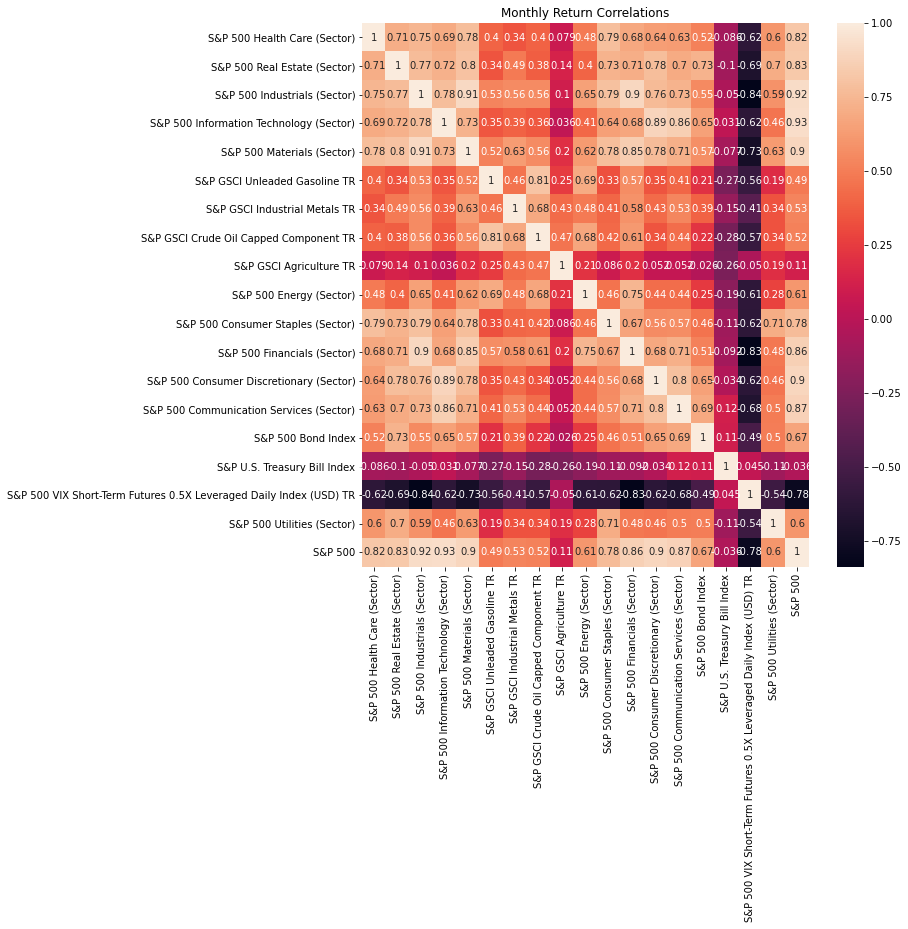

In [19]:

# Calculate and print the correlation matrix here
correlations = monthly_returns.corr()
print(correlations)

# Visualize the correlations as heatmap here
plt.figure(figsize=(10, 10))
sns.heatmap(correlations, annot=True)
plt.title('Monthly Return Correlations')
plt.show()